# Example: Simple Moving Average (SMA) Strategy

In this example we will be using the **Static Market** model as well as the **Discrete Event Driven Simulation** (DEDS) egine.

The design of this strategy is inspired by the lecture 2 of Algorithmic Trading, original which can be find in the [Algorithmic Trading Society Lectures Imperial College London](https://github.com/algotradingsoc/Lectures2022/blob/main/AlgoTradeSocLectures.ipynb)

In this example we will be investing in Google and Apple stocks using data from Jan 1st 2017 until Jan 1st 2022. If the SMA of the close price of the short horizon of 5 days is greater than the one over the long horizon of 20 days, this can indicate that the pricing is on the rise and we should buy, this is known as a bullish signal, otherwise we sell. The amount to buy and sell needs to be specified before hand, in this case is just going to be 100 shares of the company.

In [1]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev")
@suppress Pkg.add(["Dates","Plots","DataFrames"])
@info "Dependencies added"

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
[ Info: Dependencies added


## Data Generation
Use **AirBorne** to retrieve data from yahoo finance by specifying the symbols and the range of dates. In this case we will be retrieving interday data, this are OHLCV candles for each trading day.The format of the data returned we refer it as **"OHLCV_V1"**.

In [2]:
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
# To generate this data use:
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
data = get_interday_data(["AAPL","GOOG"], unix("2017-01-01"), unix("2022-01-01"))


Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,29.0375,29.0825,28.69,28.95,115127600,2017-01-03T10:30:00,1483453800,NMS,America/New_York,USD,AAPL,NMS/AAPL
2,29.005,29.1275,28.9375,28.9625,84472400,2017-01-04T10:30:00,1483540200,NMS,America/New_York,USD,AAPL,NMS/AAPL
3,29.1525,29.215,28.9525,28.98,88774400,2017-01-05T10:30:00,1483626600,NMS,America/New_York,USD,AAPL,NMS/AAPL
4,29.4775,29.54,29.1175,29.195,127007600,2017-01-06T10:30:00,1483713000,NMS,America/New_York,USD,AAPL,NMS/AAPL
5,29.7475,29.8575,29.485,29.4875,134247600,2017-01-09T10:30:00,1483972200,NMS,America/New_York,USD,AAPL,NMS/AAPL
6,29.7775,29.845,29.575,29.6925,97848400,2017-01-10T10:30:00,1484058600,NMS,America/New_York,USD,AAPL,NMS/AAPL
7,29.9375,29.9825,29.65,29.685,110354400,2017-01-11T10:30:00,1484145000,NMS,America/New_York,USD,AAPL,NMS/AAPL
8,29.8125,29.825,29.5525,29.725,108344800,2017-01-12T10:30:00,1484231400,NMS,America/New_York,USD,AAPL,NMS/AAPL
9,29.76,29.905,29.7025,29.7775,104447600,2017-01-13T10:30:00,1484317800,NMS,America/New_York,USD,AAPL,NMS/AAPL


## Using the SMA template
**Airborne** provides out of the box strategy templates that greatly simplifies the implementation of a trading strategy. In this case we will use a:
- Short horizon of 5 days
- Long horizon of 20 days.

In [4]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using AirBorne.Strategies.SMA: interday_initialize!, interday_trading_logic!
using AirBorne.Structures: summarizePerformance,TimeEvent
using Dates: DateTime


sma_initialize!(context) = interday_initialize!(context; longHorizon=20, shortHorizon=5)
sma_trading_logic! = interday_trading_logic!

# Run Simulation
# max_iter = 100

evaluationEvents = [
        TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)
    ]

@time context = run(
    data,
    sma_initialize!,
    sma_trading_logic!,
    execute_orders!,
    expose_data;
    audit=true,
    max_date=DateTime(2022, 1, 1),
    verbose=true,
    initialEvents=evaluationEvents,
)
results = summarizePerformance(data, context)
println("Done")


 19.326701 seconds (23.29 M allocations: 1.325 GiB, 3.21% gc time, 58.97% compilation time)
Done


Now we can viusalize the results by using **Plots.jl**.

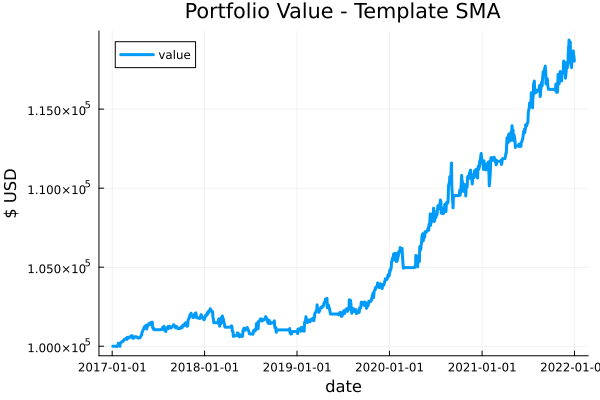

In [5]:
using Plots: plot, plot!
plot(results.date, results.dollarValue, title="Portfolio Value - Template SMA", label="value", linewidth=3, xlabel="date",ylabel="\$ USD")

##### Visualization of short and long curves
Let's have a close look at Google to see the SMA in action.

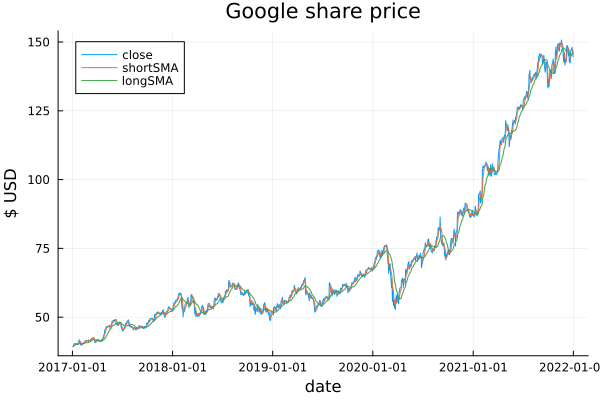

In [6]:
using AirBorne.Utils: movingAverage
goog_data = data[data[!,"symbol"].=="GOOG",:]
short = movingAverage(goog_data.close;windowSize=5)
long = movingAverage(goog_data.close;windowSize=20)
plot(goog_data.date, [goog_data.close, short, long], title="Google share price", label=["close" "shortSMA" "longSMA"], linewidth=1, xlabel="date",ylabel="\$ USD")

##### Close up on Q1 2018
In 2018 we can observe that whilst the value of the short horizon is longer the amount of stock held was 100, however as soon as the ratio went below 1 all stocks were sold making the amount of GOOG shares in the portfolio the next day.
And likewise when it returns to be larger than one an order of purchase is sent and fulfilled the next day.

```julia
using Plots: scatter!, scatter
ratio = short./long
cd_d =  (goog_data.date.>=DateTime("2018-01-01") .&& goog_data.date.<DateTime("2018-03-01"))
rd = results.date
gp = [get(x.portfolio,"NMS/GOOG",0) for x=eachrow(results)]./100
cd = rd.>=DateTime("2018-01-01") .&& rd.<DateTime("2018-03-01")
scatter(rd[cd], gp[cd], title="Close Up Q1-2018", label="Google %")
scatter!(goog_data.date[cd_d], ratio[cd_d], label="ratio s/l", mc=:red, ms=2, ma=0.5)
```

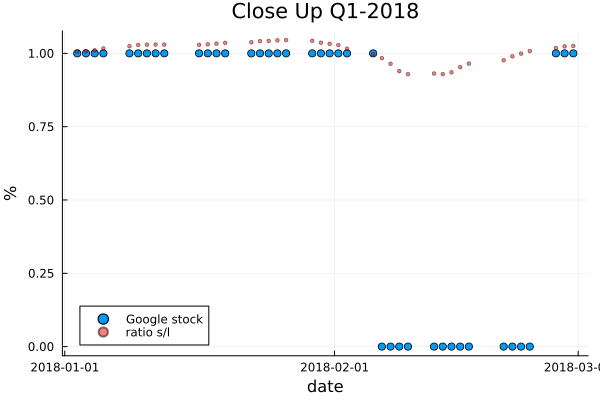

In [7]:
using Plots: scatter!, scatter
ratio = short./long
cd_d =  (goog_data.date.>=DateTime("2018-01-01") .&& goog_data.date.<DateTime("2018-03-01"))
rd = results.date
gp = [get(x.portfolio,"NMS/GOOG",0) for x=eachrow(results)]./100
cd = rd.>=DateTime("2018-01-01") .&& rd.<DateTime("2018-03-01")
scatter(rd[cd], gp[cd], title="Close Up Q1-2018", label="Google stock", xlabel="date",ylabel="%")
scatter!(goog_data.date[cd_d], ratio[cd_d], label="ratio s/l", mc=:red, ms=2, ma=0.5)


### Building your own SMA strategy
In the previous example we leveraged the strategy template provided by the AirBorne package, however if you want to deeply personalize the strategy is a good idea to build your own, as the templates are built for general use cases building your own can achieve custom behaviours and even performance improvements.

Below a SMA strategy is built from scratch

In [8]:
using  AirBorne.Utils: sortedStructInsert!
using  AirBorne.Structures: ContextTypeA, TimeEvent
using  AirBorne.Markets.StaticMarket: Order, place_order!
using Dates: Day, year
using DataFrames: DataFrame, groupby, combine, mean
using DotMaps: DotMap

function custom_initialize!(context::ContextTypeA; longHorizon::Real=100, shortHorizon::Real=10, initialCapital::Real=10^5)
    context.extra.long_horizon = longHorizon
    context.extra.short_horizon = shortHorizon
    
    ###################################
    ####  Specify Account Balance  ####
    ###################################
    context.accounts.usd = DotMap(Dict())
    context.accounts.usd.balance = initialCapital
    context.accounts.usd.currency = "USD"
    
    return nothing
end


function custom_trading_logic!(context::ContextTypeA, data::DataFrame; tune_parameters::Dict=Dict())
    ####################################
    ####  Perform SMA calculations  ####
    ####################################

    if size(data,1)<context.extra.long_horizon # Skip if not enough data
        return nothing
    else
        shortSMA(sdf_col) = mean(last(sdf_col, context.extra.short_horizon))
        longSMA(sdf_col) = mean(last(sdf_col, context.extra.long_horizon))
        sma_df=combine(groupby(data, ["symbol","exchangeName"]), :close=>shortSMA=>:SMA_S, :close=>longSMA=>:SMA_L )
        sma_df[!,:position]= ((sma_df.SMA_S .>= sma_df.SMA_L) .-0.5) .*2
    end
    
    ###########################
    ####  Generate Orders  ####
    ###########################
    for r= eachrow(sma_df)
        assetID= r.exchangeName *"/"*  r.symbol
        if r.position>0 # Set Portfolio to 100 Shares on ticker under a bullish signal
            amount = 100 - get(context.portfolio,assetID,0)  
        elseif r.position<10
            amount = get(context.portfolio,assetID,0)*-1
        end
        if amount === 0
            continue
        end
        order_specs = DotMap(Dict())
        order_specs.ticker = r.symbol
        order_specs.shares = amount # Can be replaced by r.amount
        order_specs.type = "MarketOrder"
        order_specs.account = context.accounts.usd
        order = Order(r.exchangeName, order_specs)
        place_order!(context,order) 
    end
    return nothing
end


custom_trading_logic! (generic function with 1 method)

## Test

### Add Data

### Run Simulation

In [10]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
my_initialize!(context) = custom_initialize!(context;longHorizon=30, shortHorizon=7,initialCapital=10^4)
my_trading_logic!(context,data) = custom_trading_logic!(context,data)

evaluationEvents = [
        TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)
    ]

@time context2 = run(
    data,
    my_initialize!,
    my_trading_logic!,
    execute_orders!,
    expose_data;
    verbose=true,
    audit=true,
    initialEvents=evaluationEvents,
)
results2 = summarizePerformance(data, context2)
print("Done")

 26.277665 seconds (40.36 M allocations: 2.459 GiB, 8.77% gc time, 1.03% compilation time)
Done

By comparison below it can be seen that the custom SMA performed better than the regular one, the only difference to be fair was the number of days in the long horizon and short horizon, with 30 and 7 instead of 20 and 5 from the template. However it does convey the necessary ingredients for anyone to build their own custom strategies.

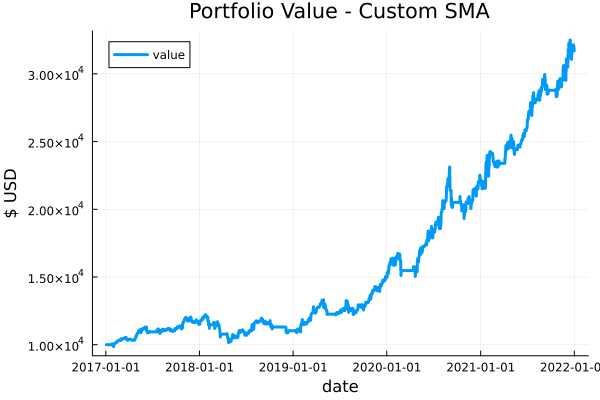

In [11]:
using Plots: plot, plot!
plot(results2.date, results2.dollarValue, title="Portfolio Value - Custom SMA", label="value", linewidth=3, xlabel="date",ylabel="\$ USD")